# Gradient-based semantle solving agent

Defines an agent that uses a discrete version of gradient descent in embedding space to find the semantle target/secret word

In [1]:
from english_words import english_words_set
import matplotlib.pyplot as plt
import numpy as np
from semantle_simulator import SemantleSimulator

## Simulator for semantle

In [2]:
sem_sim = SemantleSimulator()

In [3]:
sem_sim.target = 'missing'

## Agent capabilities

Agent reuses semantle embedding space, but could potentially use a different semantic representation. Word list is closer (~30k) to what a human could potentially recall.

In [4]:
agent_semantics = sem_sim.wv
agent_vocabulary = [w for w in list(english_words_set) if w in sem_sim.wv]
if sem_sim.target not in agent_vocabulary:
    agent_vocabulary.append(sem_sim.target)
word_embeds = np.array([agent_semantics[w] for w in agent_vocabulary])

## Similarity function and gradient representation

Measure the delta in embedding space from one word to another, and the associated delta in similarity to the target. Each guess adds to a discrete network of nodes (function value) and connecting spokes (function gradient in a specific direction)

In [5]:
def d_embed_location(i, j):
    return word_embeds[j] - word_embeds[i]

def d_target_similarity(i, j, node_similarities):
    si = node_similarities[i]
    sj = node_similarities[j]
    return sj - si

In [6]:
def register_guess(g, score, node_similarities, gradient_network):
    if g in node_similarities:
        print('duplicate guess')
        return
    node_similarities[g] = score
    spokes = []
    for j in gradient_network.keys():
        spoke_direction = d_embed_location(g, j)
        spoke_gradient = d_target_similarity(g, j, node_similarities)
        spokes.append((spoke_direction, spoke_gradient, j))
        gradient_network[j].append((-spoke_direction, -spoke_gradient, g))
    gradient_network[g] = spokes

## Make the next guess based on function/gradient

First seed a few random guesses.

In [7]:
def seed_guesses(node_sim, grad_net, n=3):
    for _ in range(n):
        g = np.random.randint(len(agent_vocabulary))
        score = sem_sim.score_guess(agent_vocabulary[g])
        register_guess(g, score, node_sim, grad_net)

Find the node with best similarity, move some random distance in the direction of steepest known gradient, and from that point find a close word not yet guessed. This could be more sophisticated but seems to work ok.

In [8]:
def get_top_node(node_sim):
    sorted_nodes = {k: v for k, v in sorted(node_sim.items(), key=lambda item: item[1])}
    return list(sorted_nodes.items())[-1]

def get_top_spoke(node, grad_net):
    sorted_spokes = [s for s in sorted(grad_net[node], key=lambda item: item[1])]
    return sorted_spokes[-1]

def semantic_leap(node, spoke, distance):
    return word_embeds[node] + spoke[0] * distance

def proximate_node(semantic_location, grad_net):
    proximities = agent_semantics.cosine_similarities(semantic_location, word_embeds)
    proximate_ids = np.argsort(proximities)
    j = 1
    while proximate_ids[-j] in grad_net:
        j = j + 1
    return proximate_ids[-j]     

def next_guess(node_sim, grad_net):
    node = get_top_node(node_sim)[0]
    spoke = get_top_spoke(node, grad_net)
    basis = (node, spoke)
    distance = np.random.rand(1) * 2
    semantic_location = semantic_leap(node, spoke, distance)
    return proximate_node(semantic_location, grad_net), basis

## Run the solving agent

In [9]:
node_similarities = {}
gradient_network = {}
seed_guesses(node_similarities, gradient_network)

guess_history = []
basis_history = []
for k in node_similarities.keys():
    guess_history.append(k)
    basis_history.append((-1, (None, 0, -1))) 

while get_top_node(node_similarities)[1] < 99:
    g, b = next_guess(node_similarities, gradient_network)
    score = sem_sim.score_guess(agent_vocabulary[g])
    register_guess(g, score, node_similarities, gradient_network)
    guess_history.append(g)
    basis_history.append(b)
    if len(guess_history) > 500:
        break
    
len(node_similarities), agent_vocabulary[g]

(151, 'missing')

## Visualise the results

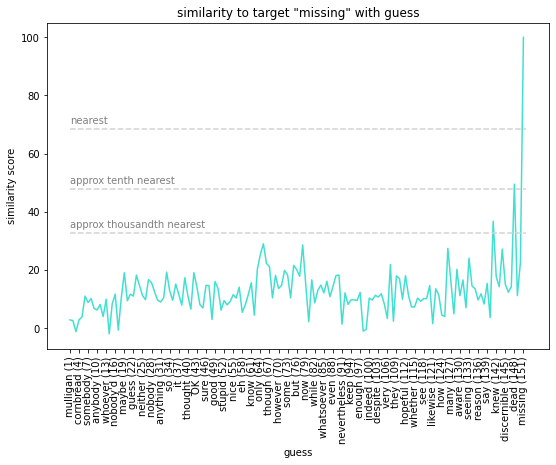

In [10]:
similarity_history = np.array([node_similarities[g] for g in guess_history])
tgt_cal = sem_sim.score_calibration()
plt.figure(figsize=(9, 6))
plt.plot(similarity_history, c='turquoise')
plt.plot([0, len(similarity_history)], [tgt_cal[0][1], tgt_cal[0][1]], '--', c='lightgrey')
plt.text(0, tgt_cal[0][1] + 2, 'nearest', c='grey') 
plt.plot([0, len(similarity_history)], [tgt_cal[1][1], tgt_cal[1][1]], '--', c='lightgrey')
plt.text(0, tgt_cal[1][1] + 2, 'approx tenth nearest', c='grey') 
plt.plot([0, len(similarity_history)], [tgt_cal[2][1], tgt_cal[2][1]], '--', c='lightgrey')
plt.text(0, tgt_cal[2][1] + 2, 'approx thousandth nearest', c='grey') 
plt.title(f'similarity to target "{sem_sim.target}" with guess')
plt.ylabel('similarity score')
plt.xlabel('guess')
xtick_lim = 46
xtick_step = max(1, int(round(len(similarity_history) / xtick_lim)))
xticks = range(0, len(similarity_history), xtick_step)
xtick_labels = [f'{agent_vocabulary[guess_history[xt]]} ({xt + 1})' for xt in xticks]
plt.xticks(xticks, xtick_labels, rotation=90)
plt.show()

### Visualise search strategy

The visualisation of the gradient descent search strategy is based on run length encoding using code published at https://stackoverflow.com/questions/1066758/find-length-of-sequences-of-identical-values-in-a-numpy-array-run-length-encodi by user Thomas Browne.

In [11]:
def rle(inarray):
        """ run length encoding. Partial credit to R rle function. 
            Multi datatype arrays catered for including non Numpy
            returns: tuple (runlengths, startpositions, values) """
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]               # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)   # must include last element posi
            z = np.diff(np.append(-1, i))       # run lengths
            p = np.cumsum(np.append(0, z))[:-1] # positions
            return(z, p, ia[i])

In [12]:
top_node_history = np.array([b[0] for b in basis_history])
rls_top_node = rle(top_node_history)
idrl_top_node = np.repeat(np.arange(rls_top_node[0].size), rls_top_node[0])
spoke_node_history = np.array([b[1][2] for b in basis_history])
rls_spoke_node = rle(spoke_node_history)
idrl_spoke_node = np.repeat(np.arange(rls_spoke_node[0].size), rls_spoke_node[0])

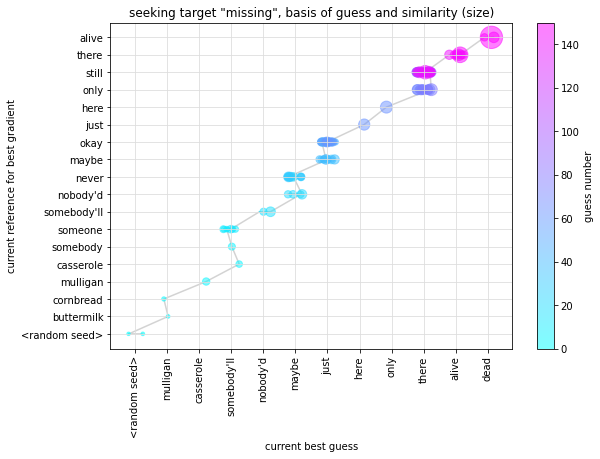

In [13]:
word_array = np.array(agent_vocabulary)
s_sim_hist = np.maximum(similarity_history, 0.1)
h_noise = np.random.rand(len(top_node_history)) * 0.5 - 0.25
h_labels = word_array[rls_top_node[2]]
h_labels[0] = '<random seed>'
v_labels = word_array[rls_spoke_node[2]]
v_labels[0] = '<random seed>'

plt.figure(figsize=(9, 6))
plt.scatter(idrl_top_node + h_noise, idrl_spoke_node, s=(s_sim_hist * 5),
            c=range(len(top_node_history)), cmap='cool', alpha=0.5, zorder=1)
plt.plot(idrl_top_node + h_noise, idrl_spoke_node, c='lightgrey', zorder=0)
plt.xticks(np.arange(rls_top_node[0].size), labels=h_labels, rotation=90)
plt.xlabel('current best guess')
plt.yticks(np.arange(rls_spoke_node[0].size), labels=v_labels)
plt.ylabel('current reference for best gradient')
plt.colorbar(label='guess number')
plt.grid('on', color='#ddd')
plt.title(f'seeking target "{sem_sim.target}", basis of guess and similarity (size)')
plt.show()

### Visualise results and search together

In [14]:
basis_pairs_top = np.repeat(h_labels, rls_top_node[0])
basis_pairs_spoke = np.repeat(v_labels, rls_spoke_node[0])
basis_pairs_label = np.char.add(np.char.add(basis_pairs_spoke, ' > '), basis_pairs_top)
rls_basis_pairs = rle(basis_pairs_label)

idrl_basis_pair = np.repeat(np.arange(rls_basis_pairs[0].size), rls_basis_pairs[0])
idrl_offsets = np.concatenate([np.arange(rls_basis_pairs[0][i]) for i in range(rls_basis_pairs[0].size)])
basis_x_pos = idrl_basis_pair + idrl_offsets / np.max(idrl_offsets) / 2
cumul_similarity_max = np.maximum.accumulate(similarity_history)
rls_new_sim_max = rle(cumul_similarity_max)
reference_labels = np.char.add('+ ', word_array[spoke_node_history[rls_basis_pairs[1]]])
reference_labels[0] = ''

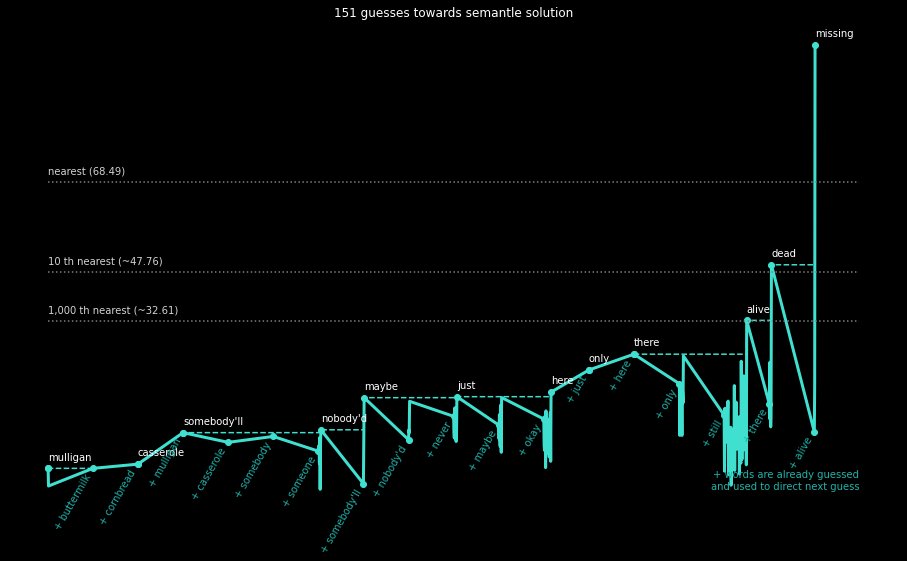

In [15]:
plt.figure(figsize=(16, 9), facecolor='black')
plt.plot(basis_x_pos, similarity_history, c='turquoise', lw=3)
plt.plot(basis_x_pos, cumul_similarity_max, '--', c='turquoise')
plt.scatter(basis_x_pos[rls_new_sim_max[1]], cumul_similarity_max[rls_new_sim_max[1]], c='turquoise')
for m in rls_new_sim_max[1]:
    plt.text(basis_x_pos[m], cumul_similarity_max[m] + 2, word_array[guess_history[m]], c='white')
for i in range(rls_basis_pairs[0].size):
    plt.text(i, similarity_history[rls_basis_pairs[1][i]] - 1, reference_labels[i] + ' ',
             rotation=60, ha='right', rotation_mode='anchor', c='lightseagreen')
plt.scatter(range(rls_basis_pairs[0].size), similarity_history[rls_basis_pairs[1]], c='turquoise')

plt.plot([0, rls_basis_pairs[0].size], [tgt_cal[0][1], tgt_cal[0][1]], ':', c='grey')
plt.text(0, tgt_cal[0][1] + 2, f'nearest ({tgt_cal[0][1]:.2f})', c='lightgrey') 
plt.plot([0, rls_basis_pairs[0].size], [tgt_cal[1][1], tgt_cal[1][1]], ':', c='grey')
plt.text(0, tgt_cal[1][1] + 2, f'10 th nearest (~{tgt_cal[1][1]:.2f})', c='lightgrey') 
plt.plot([0, rls_basis_pairs[0].size], [tgt_cal[2][1] + 4, tgt_cal[2][1] + 4], ':', c='grey')
plt.text(0, tgt_cal[2][1] + 6, f'1,000 th nearest (~{tgt_cal[2][1]:.2f})', c='lightgrey') 

plt.axis('off')
plt.title(f'{len(guess_history)} guesses towards semantle solution', c='white')
plt.text(rls_basis_pairs[0].size, -2, '+ words are already guessed\nand used to direct next guess', ha='right', c='lightseagreen')

plt.show()